# Soil-MC-CP code
This is the repository related to the publication titled "Using Monte Carlo conformal prediction to evaluate the uncertainty of deep learning soil spectral models"

### Misc (functions and packages)

In [1]:
# import the package
# import os
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
def reset():
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

def create_model(train_data, lr=0.001, start_filters=32, dropout_rate=0.2):
    reset()
    
    input = Input(shape=train_data.shape[1:])

    x = Conv1D(start_filters, 5, activation="relu")(input)  # Convolutional layer 1
    x = MaxPool1D(2)(x)                                     # Max pooling layer 1   
    x = MCDropout(dropout_rate)(x)                          # Dropout layer 1
    
    x = Conv1D(start_filters * 2, 5, activation="relu")(x)  # Convolutional layer 2
    x = MaxPool1D(2)(x)                                     # Max pooling layer 2                                         
    x = MCDropout(dropout_rate)(x)                          # Dropout layer 2

    x = Conv1D(start_filters * 4, 5, activation="relu")(x)  # Convolutional layer 3
    x = MaxPool1D(2)(x)                                     # Max pooling layer 3
    x = MCDropout(dropout_rate)(x)                          # Dropout layer 3

    x = Conv1D(start_filters * 8, 5, activation="relu")(x)  # Convolutional layer 4
    x = MaxPool1D(2)(x)                                     # Max pooling layer 4
    x = MCDropout(dropout_rate)(x)                          # Dropout layer 4
    
    x = Flatten()(x) # Flatten

    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=[])
    return model

In [4]:
# Function to produce 100 forward passes through the model
def monte_carlo(model, test_X, scaler, num_predictions=100):
    prediction_results = []

    for _ in range(num_predictions):
        Y_test_pred_scaled = model.predict(test_X, verbose=0) # set verbose to 0 to avoid printing the progress bar
        Y_test_pred = scaler.inverse_transform(Y_test_pred_scaled)
        Y_test_pred = Y_test_pred.reshape(-1)
        prediction_results.append(Y_test_pred)

    prediction_results = np.array(prediction_results)
    return prediction_results

In [5]:
# Function to calculate MPIW and PICP
def calculate_picp(prediction_results, Y_test, alpha=0.1, print_results=True):

    # Calculate prediction interval as 95th and 5th quantile of the predictions
    n = len(Y_test)
    upper_bounds = []
    lower_bounds = []
    for i in range(0, n):
        upper_mc = np.quantile(prediction_results[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        lower_mc = np.quantile(prediction_results[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds.append(upper_mc)
        lower_bounds.append(lower_mc)

    # Convert lists to numpy arrays
    upper_bounds = np.array(upper_bounds)
    lower_bounds = np.array(lower_bounds)

    # Prediction interval for the test set
    prediction_sets = [lower_bounds, upper_bounds]
    PIW = upper_bounds - lower_bounds
    
    MPIW = np.mean(PIW)
    
    # Coverage
    empirical_coverage = ((Y_test >= prediction_sets[0]) & (Y_test <= prediction_sets[1])).mean()

    if print_results:
        print(f"The MPIW is {MPIW:.2f}")
        print(f"The PICP at {(1-alpha)*100}% is {empirical_coverage:.2f}")
        plt.hist(PIW, bins=50, edgecolor='k', density=True)
        plt.xlabel('Prediction Interval Width (PIW)')
        plt.ylabel('Density')
        plt.title('Density Distribution of Prediction Interval Width (PIW)')
        plt.show()

    return MPIW, empirical_coverage

In [6]:
# Function to calculate PIW
def calculate_piw(prediction_results, Y_test, alpha=0.1):

    # Calculate prediction interval as 95th and 5th quantile of the predictions
    n = len(Y_test)
    upper_bounds = []
    lower_bounds = []
    for i in range(0, n):
        upper_mc = np.quantile(prediction_results[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        lower_mc = np.quantile(prediction_results[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds.append(upper_mc)
        lower_bounds.append(lower_mc)

    # Convert lists to numpy arrays
    upper_bounds = np.array(upper_bounds)
    lower_bounds = np.array(lower_bounds)

    # Prediction interval for the test set
    PIW = upper_bounds - lower_bounds

    return PIW

In [7]:
def conformal_prediction(model, calibration_X, calibration_Y, test_X, test_Y, scaler, alpha=0.1, print_results=False):
    prediction_sets = []
    empirical_coverage = []
    n = len(calibration_Y)
    # Calibration with external calibration set
    cal_predic = np.squeeze(np.asarray(model.predict(calibration_X, batch_size=1000, verbose=0)))
    cal_predic = scaler.inverse_transform(cal_predic.reshape(-1, 1)).flatten()
    cal_scores = np.abs(calibration_Y - cal_predic)
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')
    PIW = qhat * 2
    if print_results:
        # print("The qhat is ", qhat)
        print(f"The PIW is {PIW:.2f} for every sample")
    
    # Prediction interval for the test set
    prediction = np.squeeze(np.asarray(model.predict(test_X, batch_size=1000, verbose=0)))
    prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
    prediction_sets = [prediction - qhat, prediction + qhat]

    # Coverage
    empirical_coverage = ((test_Y >= prediction_sets[0]) & (test_Y <= prediction_sets[1])).mean()
    if print_results:
        print(f"The PICP at {(1-alpha)*100}% is {empirical_coverage:.2f}")
    return PIW, empirical_coverage

In [ ]:
def MC_CP_simple(calibration_Y, test_Y, mc_predictions_cali, mc_predictions_test, alpha=0.1, print_results=False):
    # Find 0.05 and 0.95 quantiles for calibration set MC predictions
    n = len(calibration_Y)
    upper_bounds_cali = []
    lower_bounds_cali = []
    for i in range(0, n):
        upper_mc = np.quantile(mc_predictions_cali[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        lower_mc = np.quantile(mc_predictions_cali[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds_cali.append(upper_mc)
        lower_bounds_cali.append(lower_mc)

    # Find 0.05 and 0.95 quantiles for test set MC predictions
    n = len(test_Y)
    upper_bounds_test = []
    lower_bounds_test = []
    for i in range(0, n):
        test_upper_mc = np.quantile(mc_predictions_test[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        test_lower_mc = np.quantile(mc_predictions_test[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds_test.append(test_upper_mc)
        lower_bounds_test.append(test_lower_mc)

    # Calculate conformity scores
    cal_scores = np.maximum(calibration_Y-upper_bounds_cali, lower_bounds_cali-calibration_Y)
    qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, method='higher')
    
    # Prediction interval for the test set
    prediction_sets = [lower_bounds_test - qhat, upper_bounds_test + qhat]
    PIW = prediction_sets[1] - prediction_sets[0]
    MPIW = np.mean(PIW)
    
    # Coverage (PICP)
    empirical_coverage = ((test_Y >= prediction_sets[0]) & (test_Y <= prediction_sets[1])).mean()

    # Print results
    if print_results:
        print(f"The qhat is {qhat:.2f}")
        print(f"The MPIW is {MPIW:.2f}")
        print(f"The PICP at {(1-alpha)*100}% is {empirical_coverage:.2f}")

        plt.hist(PIW, bins=50, edgecolor='k', density=True)
        plt.xlabel('Prediction Interval Width (PIW)')
        plt.ylabel('Density')
        plt.title('Density Distribution of Prediction Interval Width (PIW)')
        plt.show()   
    
    return MPIW, empirical_coverage

In [9]:
# Calculate PIW for MC-CP
def MC_CP_piw(calibration_Y, test_Y, mc_predictions_cali, mc_predictions_test, alpha=0.1):
    # Find 0.05 and 0.95 quantiles for calibration set MC predictions
    n = len(calibration_Y)
    upper_bounds_cali = []
    lower_bounds_cali = []
    for i in range(0, n):
        upper_mc = np.quantile(mc_predictions_cali[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        lower_mc = np.quantile(mc_predictions_cali[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds_cali.append(upper_mc)
        lower_bounds_cali.append(lower_mc)

    # Find 0.05 and 0.95 quantiles for test set MC predictions
    n = len(test_Y)
    upper_bounds_test = []
    lower_bounds_test = []
    for i in range(0, n):
        test_upper_mc = np.quantile(mc_predictions_test[:, i], np.ceil((n + 1) * (1-alpha/2)) / n, method='higher')
        test_lower_mc = np.quantile(mc_predictions_test[:, i], np.ceil((n + 1) * (alpha/2)) / n, method='higher')
        upper_bounds_test.append(test_upper_mc)
        lower_bounds_test.append(test_lower_mc)

    # Calculate conformity scores
    cal_scores = np.maximum(Y_cali-upper_bounds_cali, lower_bounds_cali-Y_cali)
    qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, method='higher')
    
    # Prediction interval for the test set
    prediction_sets = [lower_bounds_test - qhat, upper_bounds_test + qhat]
    PIW = prediction_sets[1] - prediction_sets[0]
    return PIW

### Import data

In [10]:
out_of_domain_prop = pd.read_csv('out_of_domain_prop.csv')
in_domain_prop = pd.read_csv('in_domain_prop.csv')
out_of_domain_spec = pd.read_csv("out_of_domain_spec.csv")
in_domain_spec = pd.read_csv("in_domain_spec.csv")

in_domain_spec = np.expand_dims(in_domain_spec.iloc[:, 1:].values, -1)
X_independent = np.expand_dims(out_of_domain_spec.iloc[:, 1:].values, -1)
Y_independent = out_of_domain_prop['property']

In [11]:
# Split train, val and test
X_train, X_test, Y_train, Y_test = train_test_split(in_domain_spec, in_domain_prop['property'], test_size=0.15, random_state=52)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.6666, random_state=52)
X_cali, X_val, Y_cali, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=52)

# Generate scaler and scale the data
scaler = MinMaxScaler()
scaler.fit(Y_train.values.reshape(-1, 1))
Y_train_scaled = scaler.transform(Y_train.values.reshape(-1, 1))
Y_val_scaled = scaler.transform(Y_val.values.reshape(-1, 1))
Y_test_scaled = scaler.transform(Y_test.values.reshape(-1, 1))
Y_cali_scaled = scaler.transform(Y_cali.values.reshape(-1, 1))

### Training model

In [ ]:
cb_lr = ReduceLROnPlateau(patience=50)
cb_stop = EarlyStopping(patience=60)

m1 = create_model(X_train, start_filters=32)
history = m1.fit(X_train, Y_train_scaled,
    validation_data=(X_val, Y_val_scaled),
    batch_size=300,
    epochs=500,
    callbacks=[cb_lr, cb_stop],
)

In [ ]:
# Show training history
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [12]:
# Loading existing model
m1 = load_model("m1.h5", custom_objects={"MCDropout": MCDropout, "tf": tf, "mse": tf.keras.losses.mse})

### Generate forward passes

In [13]:
# Generate 100 forward passes through the model
prediction_MC = monte_carlo(m1, X_test, scaler, num_predictions=100)
prediction_MC_high_clay = monte_carlo(m1, X_independent, scaler, num_predictions=100)
mc_predictions_cali = monte_carlo(m1, X_cali, scaler, num_predictions=100)
mc_predictions_test = monte_carlo(m1, X_test, scaler, num_predictions=100)
mc_predictions_independent = monte_carlo(m1, X_independent, scaler, num_predictions=100)

In [ ]:
# Get prediction interval width (PIW)
PIW_low_clay = calculate_piw(prediction_MC, Y_test, alpha=0.1)
PIW_high_clay = calculate_piw(prediction_MC_high_clay, Y_independent, alpha=0.1)
PIW_MC_CP_low_clay = MC_CP_piw(Y_cali, Y_test, mc_predictions_cali, mc_predictions_test, alpha=0.1)
PIW_MC_CP_high_clay = MC_CP_piw(Y_cali, Y_independent, mc_predictions_cali, mc_predictions_independent, alpha=0.1)

In [41]:
MC_MPIW_90_in, MC_cover_90_in = calculate_picp(prediction_MC, Y_test, alpha=0.1, print_results=False)
MC_MPIW_90_out, MC_cover_90_out = calculate_picp(prediction_MC_high_clay, Y_independent, alpha=0.1, print_results=False)
CP_PIW, CP_90_cover_in = conformal_prediction(m1, X_cali, Y_cali, X_test, Y_test, scaler, alpha=0.1, print_results=False)
CP_PIW_independent, CP_90_cover_out = conformal_prediction(m1, X_cali, Y_cali, X_independent, Y_independent, scaler, alpha=0.1, print_results=False)
MCCP_MPIW_90_in, MCCP_cover_90_in = MC_CP_simple(Y_cali, Y_test, mc_predictions_cali, mc_predictions_test, alpha=0.1, print_results=False)
MCCP_MPIW_90_out, MCCP_cover_90_out = MC_CP_simple(Y_cali, Y_independent, mc_predictions_cali, mc_predictions_independent, alpha=0.1, print_results=False)

In [24]:
# Calculate coverage
p_intervals = range(0, 105, 5)

# MC in-domain
coverage_probs_mc = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = calculate_picp(prediction_MC, Y_test, alpha=(1 - 99/ 100), print_results=False)
    else:
        MPIW, PICP = calculate_picp(prediction_MC, Y_test, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_mc.append(PICP)

# MC out-of-domain
coverage_probs_mc_independent = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = calculate_picp(prediction_MC_high_clay, Y_independent, alpha=(1 - 99 / 100), print_results=False)
    else:
        MPIW, PICP = calculate_picp(prediction_MC_high_clay, Y_independent, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_mc_independent.append(PICP)

# Conformal in-domain
coverage_probs_conformal = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = conformal_prediction(m1, X_cali, Y_cali, X_test, Y_test, scaler, alpha=(1 - 99 / 100), print_results=False)
    else:
        MPIW, PICP = conformal_prediction(m1, X_cali, Y_cali, X_test, Y_test, scaler, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_conformal.append(PICP)

# Conformal out-of-domain
coverage_probs_conformal_independent = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = conformal_prediction(m1, X_cali, Y_cali, X_independent, Y_independent, scaler, alpha=(1 - 99 / 100), print_results=False)
    else:
        MPIW, PICP = conformal_prediction(m1, X_cali, Y_cali, X_independent, Y_independent, scaler, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_conformal_independent.append(PICP)

# MC-CP in-domain
coverage_probs_mccp = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = MC_CP_simple(Y_cali, Y_test, mc_predictions_cali, mc_predictions_test, alpha=(1 - 99 / 100), print_results=False)
    else:
        MPIW, PICP = MC_CP_simple(Y_cali, Y_test, mc_predictions_cali, mc_predictions_test, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_mccp.append(PICP)

# MC-CP out-of-domain
coverage_probs_mccp_independent = []
for alpha100 in p_intervals:
    if alpha100 == 100:
        # Ensure the prediction interval covers everything
        MPIW, PICP = MC_CP_simple(Y_cali, Y_independent, mc_predictions_cali, mc_predictions_independent, alpha=(1 - 99 / 100), print_results=False)
    else:
        MPIW, PICP = MC_CP_simple(Y_cali, Y_independent, mc_predictions_cali, mc_predictions_independent, alpha=(1 - alpha100 / 100), print_results=False)
    coverage_probs_mccp_independent.append(PICP)

### Generate figures and tables

In [20]:
# Table 3: Results of the convolutional neural network modelling. R2 stands for coefficient of determination, and RMSE stands for root mean square error.

# Predict Y_test_scaled for in-domain samples
Y_test_pred_scaled = m1.predict(X_test, verbose=0)
Y_test_pred = scaler.inverse_transform(Y_test_pred_scaled)
Y_test_pred = Y_test_pred.reshape(-1)
r2_in = r2_score(Y_test, Y_test_pred)
rmse_in = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Predict Y_test_scaled for out-of-domain samples
Y_independent_pred_scaled = m1.predict(X_independent, verbose=0)
Y_independent_pred = scaler.inverse_transform(Y_independent_pred_scaled)
Y_independent_pred = Y_independent_pred.reshape(-1)
r2_out = r2_score(Y_independent, Y_independent_pred)
rmse_out = np.sqrt(mean_squared_error(Y_independent, Y_independent_pred))

results = pd.DataFrame({
    "In-domain test set": [f"{r2_in:.2f}", f"{rmse_in:.2f}"],
    "Out-of-domain test set": [f"{r2_out:.2f}", f"{rmse_out:.2f}"]
}, index=["R2", "RMSE"])
print(results)

     In-domain test set Out-of-domain test set
R2                 0.89                  -6.55
RMSE               3.48                   9.59


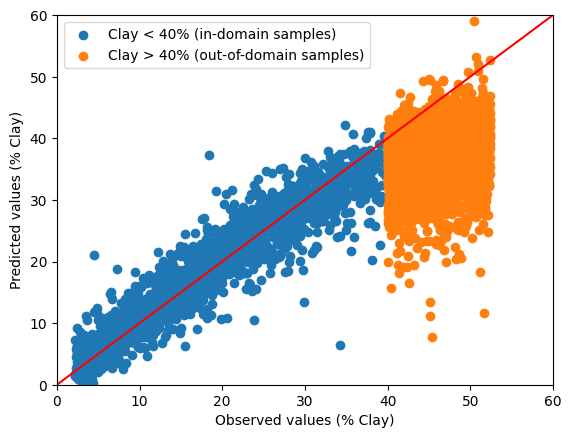

In [21]:
# Figure 1: Relationship between the observed and predicted clay content (%) of the convolutional neural network model for in-domain testing set and out-of-domain samples.
plt.scatter(Y_test, Y_test_pred, label='Clay < 40% (in-domain samples)')
plt.scatter(Y_independent, Y_independent_pred, label='Clay > 40% (out-of-domain samples)')
plt.xlabel('Observed values (% Clay)')
plt.ylabel('Predicted values (% Clay)')
plt.plot([0, 60], [0, 60], color='red')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.legend()
plt.show()

(25.0, 45.0)

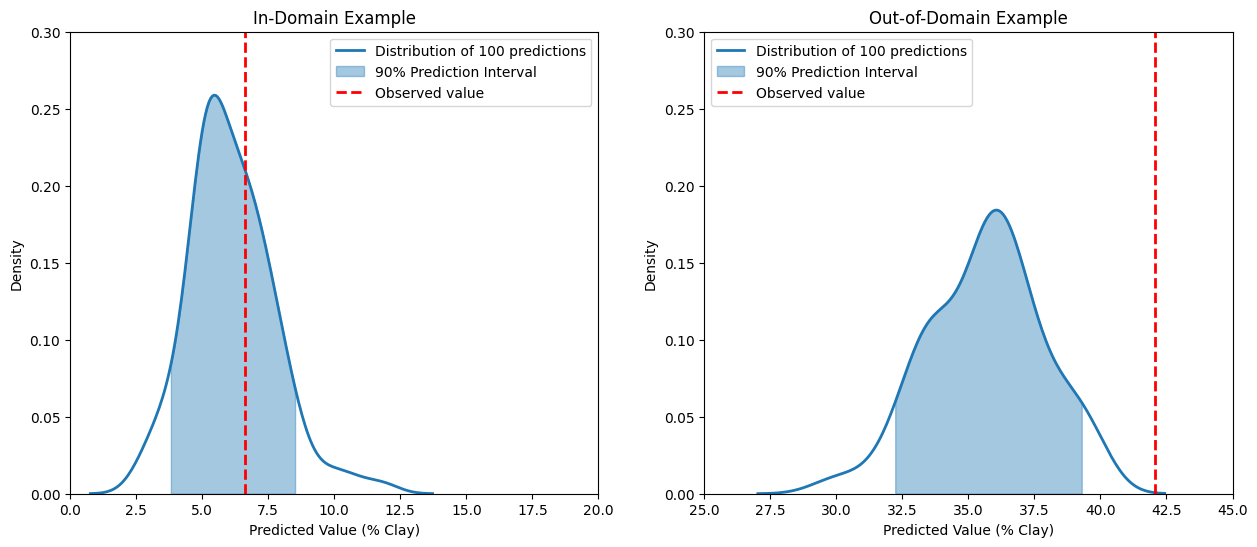

In [22]:
# Figure 2: Examples of the distribution of 100 predictions for an in-domain and an out-of-domain sample using MC dropout. Shaded areas are the 90 % prediction interval. 
# The 90 % prediction interval of the in-domain example covered the observed value while the 90 % prediction interval of the out-of-domain example did not cover the observed value.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# In-domain example
kde1 = gaussian_kde(prediction_MC[:, 621])
g1 = sns.kdeplot(prediction_MC[:, 621], label = "Distribution of 100 predictions", fill=False, color='#1f77b4', linewidth=2, ax=axes[0])

lower_bound_in = np.percentile(prediction_MC[:, 621], 5)
upper_bound_in = np.percentile(prediction_MC[:, 621], 95)

x = np.linspace(0, 45, 2500)
kde1_y = kde1(x)

axes[0].fill_between(x, kde1_y, where=(x >= lower_bound_in) & (x <= upper_bound_in), color='#1f77b4', alpha=0.4, label='90% Prediction Interval')
axes[0].axvline(x=Y_test.iloc[621], label = 'Observed value', color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Value (% Clay)')
axes[0].set_ylabel('Density')
axes[0].set_title('In-Domain Example')
axes[0].legend()
axes[0].set_ylim(0, 0.3)
axes[0].set_xlim(0, 20)


# Out-of-domain example
kde2 = gaussian_kde(prediction_MC_high_clay[:, 437])
g2 = sns.kdeplot(prediction_MC_high_clay[:, 437], label = "Distribution of 100 predictions", fill=False, color='#1f77b4', linewidth=2, ax=axes[1])

lower_bound_out = np.percentile(prediction_MC_high_clay[:, 437], 5)
upper_bound_out = np.percentile(prediction_MC_high_clay[:, 437], 95)

kde2_y = kde2(x)

axes[1].fill_between(x, kde2_y, where=(x >= lower_bound_out) & (x <= upper_bound_out), color='#1f77b4', alpha=0.4, label='90% Prediction Interval')
axes[1].axvline(x=Y_independent.iloc[437], label = 'Observed value', color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Value (% Clay)')
axes[1].set_ylabel('Density')
axes[1].set_title('Out-of-Domain Example')
axes[1].legend()
axes[1].set_ylim(0, 0.3)
axes[1].set_xlim(25, 45)

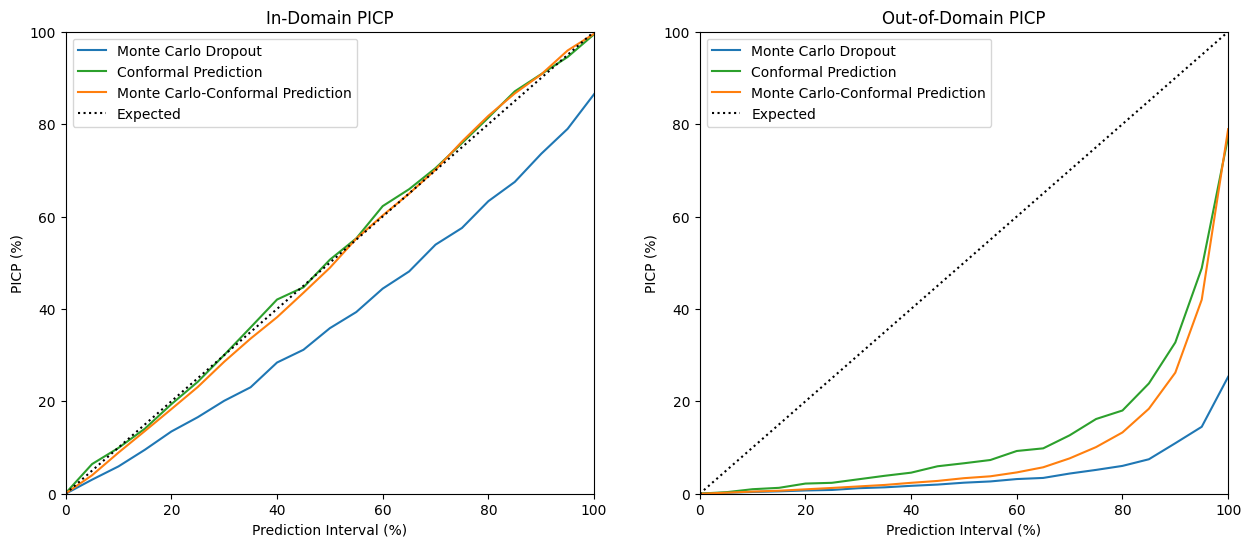

In [25]:
# Figure 3: Prediction interval coverage probability (PICP) of in-domain and out-of-domain samples at different prediction intervals for Monte Carlo dropout, conformal prediction, and Monte Carlo-conformal prediction.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# In-domain sample
axes[0].plot(p_intervals, [prob * 100 for prob in coverage_probs_mc], "#1f77b4", label = "Monte Carlo Dropout")
axes[0].plot(p_intervals, [prob * 100 for prob in coverage_probs_conformal], "#2ca02c", label = "Conformal Prediction")
axes[0].plot(p_intervals, [prob * 100 for prob in coverage_probs_mccp], "#ff7f0e", label = "Monte Carlo-Conformal Prediction")
axes[0].set_xlabel('Prediction Interval (%)')
axes[0].set_ylabel('PICP (%)')
axes[0].set_title('In-Domain PICP')
axes[0].set_ylim(0, 100)  # Set the y-axis range from 0 to 100
axes[0].set_xlim(0, 100)  # Set the x-axis range from 0 to 100
axes[0].plot([0, 100], [0, 100], linestyle='dotted', color='black', label = "Expected")  # Add dotted line for 1:1 line
axes[0].legend()

# Out-of-domain sample
axes[1].plot(p_intervals, [prob * 100 for prob in coverage_probs_mc_independent], "#1f77b4", label = "Monte Carlo Dropout")
axes[1].plot(p_intervals, [prob * 100 for prob in coverage_probs_conformal_independent], "#2ca02c", label = "Conformal Prediction")
axes[1].plot(p_intervals, [prob * 100 for prob in coverage_probs_mccp_independent], "#ff7f0e", label = "Monte Carlo-Conformal Prediction")
axes[1].set_xlabel('Prediction Interval (%)')
axes[1].set_ylabel('PICP (%)')
axes[1].set_title('Out-of-Domain PICP')
axes[1].set_ylim(0, 100)  # Set the y-axis range from 0 to 100
axes[1].set_xlim(0, 100)  # Set the x-axis range from 0 to 100
axes[1].plot([0, 100], [0, 100], linestyle='dotted', color='black', label = "Expected")  # Add dotted line for 1:1 line
axes[1].legend()

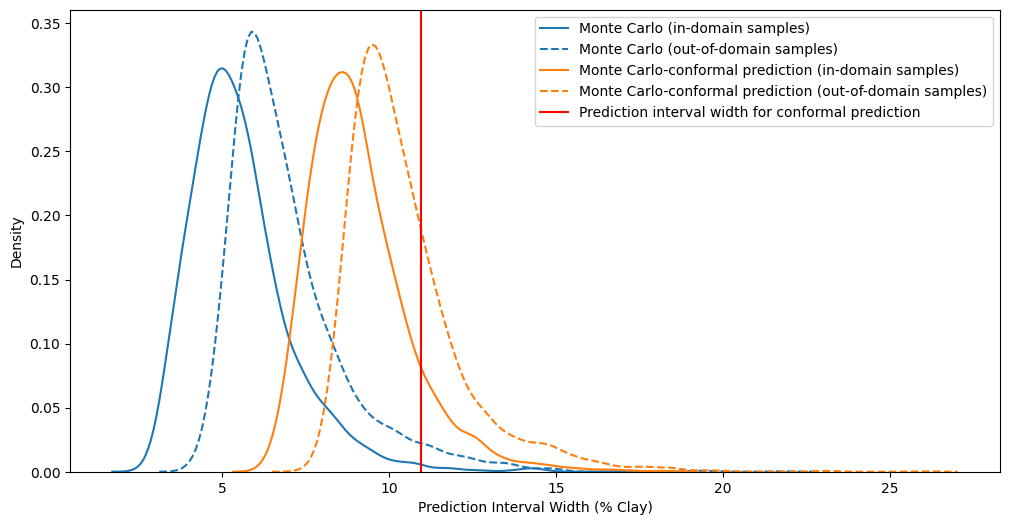

In [33]:
# Figure 4: Distribution of prediction interval width of Monte Carlo dropout, conformal prediction, and Monte Carlo-conformal prediction for in-domain and out-of-domain samples.
plt.figure(figsize=(12, 6))

sns.kdeplot(PIW_low_clay, label="Monte Carlo (in-domain samples)", color="#1f77b4")
sns.kdeplot(PIW_high_clay, label="Monte Carlo (out-of-domain samples)", linestyle="--", color="#1f77b4")
sns.kdeplot(PIW_MC_CP_low_clay, label="Monte Carlo-conformal prediction (in-domain samples)", color="#ff7f0e")
sns.kdeplot(PIW_MC_CP_high_clay, label="Monte Carlo-conformal prediction (out-of-domain samples)", linestyle="--", color="#ff7f0e")
plt.axvline(x=CP_PIW, color='red', label='Prediction interval width for conformal prediction')
plt.xlabel('Prediction Interval Width (% Clay)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [43]:
#Table 4: Results of uncertainty quantification by Monte Carlo dropout, conformal prediction, and Monte Carlo-conformal prediction. PICP stands for prediction interval coverage probability, and MPIW stands for mean prediction interval width.
table4 = pd.DataFrame({
    "90% PICP in-domain": [round(MC_cover_90_in, 2), round(CP_90_cover_in, 2), round(MCCP_cover_90_in, 2)],
    "MPIW (%) in-domain": [round(MC_MPIW_90_in, 2), round(CP_PIW, 2), round(MCCP_MPIW_90_in, 2)],
    "90% PICP out-of-domain": [round(MC_cover_90_out, 2), round(CP_90_cover_out, 2), round(MCCP_cover_90_out, 2)],
    "MPIW (%) out-of-domain": [round(MC_MPIW_90_out, 2), round(CP_PIW, 2), round(MCCP_MPIW_90_out, 2)]
}, index=["Monte Carlo dropout", "Conformal prediction", "Monte Carlo-conformal prediction"])
print(table4)

                                  90% PICP in-domain  MPIW (%) in-domain  \
Monte Carlo dropout                             0.74                5.55   
Conformal prediction                            0.91               10.99   
Monte Carlo-conformal prediction                0.91                9.11   

                                  90% PICP out-of-domain  \
Monte Carlo dropout                                 0.11   
Conformal prediction                                0.33   
Monte Carlo-conformal prediction                    0.26   

                                  MPIW (%) out-of-domain  
Monte Carlo dropout                                 6.93  
Conformal prediction                               10.99  
Monte Carlo-conformal prediction                   10.46  
